In [41]:
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename

## SET PARAMETERS

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing*.
- `ROOT_FP`: Path to root of Brieflow output directory*.

*Note: Paths can be absolute or relative to where workflows are run from.

In [42]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "analysis_root/"

### Generate maps of metadata, and check if initial sites is a logical choice

In [43]:
# TODO: Figure out good way to use testing data for example analysis...
# for now just use copied files from denali screen

TEST_WELL = "B1"
TEST_CYCLE = 1

In [44]:
ph_test_metadata_fp = f"{ROOT_FP}/preprocess/metadata/phenotype/" + get_filename(
    {"well": TEST_WELL}, "combined_metadata", "tsv"
)
ph_test_metadata = pd.read_csv(ph_test_metadata_fp, sep="\t")

sbs_test_metadata_fp = f"{ROOT_FP}/preprocess/metadata/sbs/" + get_filename(
    {"well": TEST_WELL, "cycle": TEST_CYCLE}, "combined_metadata", "tsv"
)
sbs_test_metadata = pd.read_csv(sbs_test_metadata_fp, sep="\t")
sbs_test_metadata

# TODO: Address this properly in metadata extraction
# convert the lists in the x,y,z data to numbers
# ph_test_metadata[['x_data', 'y_data', 'z_data']] = ph_test_metadata[['x_data', 'y_data', 'z_data']].applymap(lambda x: float(x.strip("[]")))
# sbs_test_metadata[['x_data', 'y_data', 'z_data']] = sbs_test_metadata[['x_data', 'y_data', 'z_data']].applymap(lambda x: float(x.strip("[]")))

,x_data,y_data,z_data,pfs_offset,tile,filename,channels,pixel_size_x,pixel_size_y
0,[33049.0],[-35283.0],[3141.06],NaN,1,data/sbs/real_images/P001_SBS_10x_C1_Wells-A1_...,5,1.30,1.30
1,[33109.33587666775],[-35262.48654487596],[0.0],NaN,2,data/sbs/empty_images/P001_SBS_10x_C1_Wells-A1...,5,0.65,0.65
2,[34602.4],[-26403.2],[3126.46],NaN,100,data/sbs/real_images/P001_SBS_10x_C1_Wells-A1_...,5,1.30,1.30


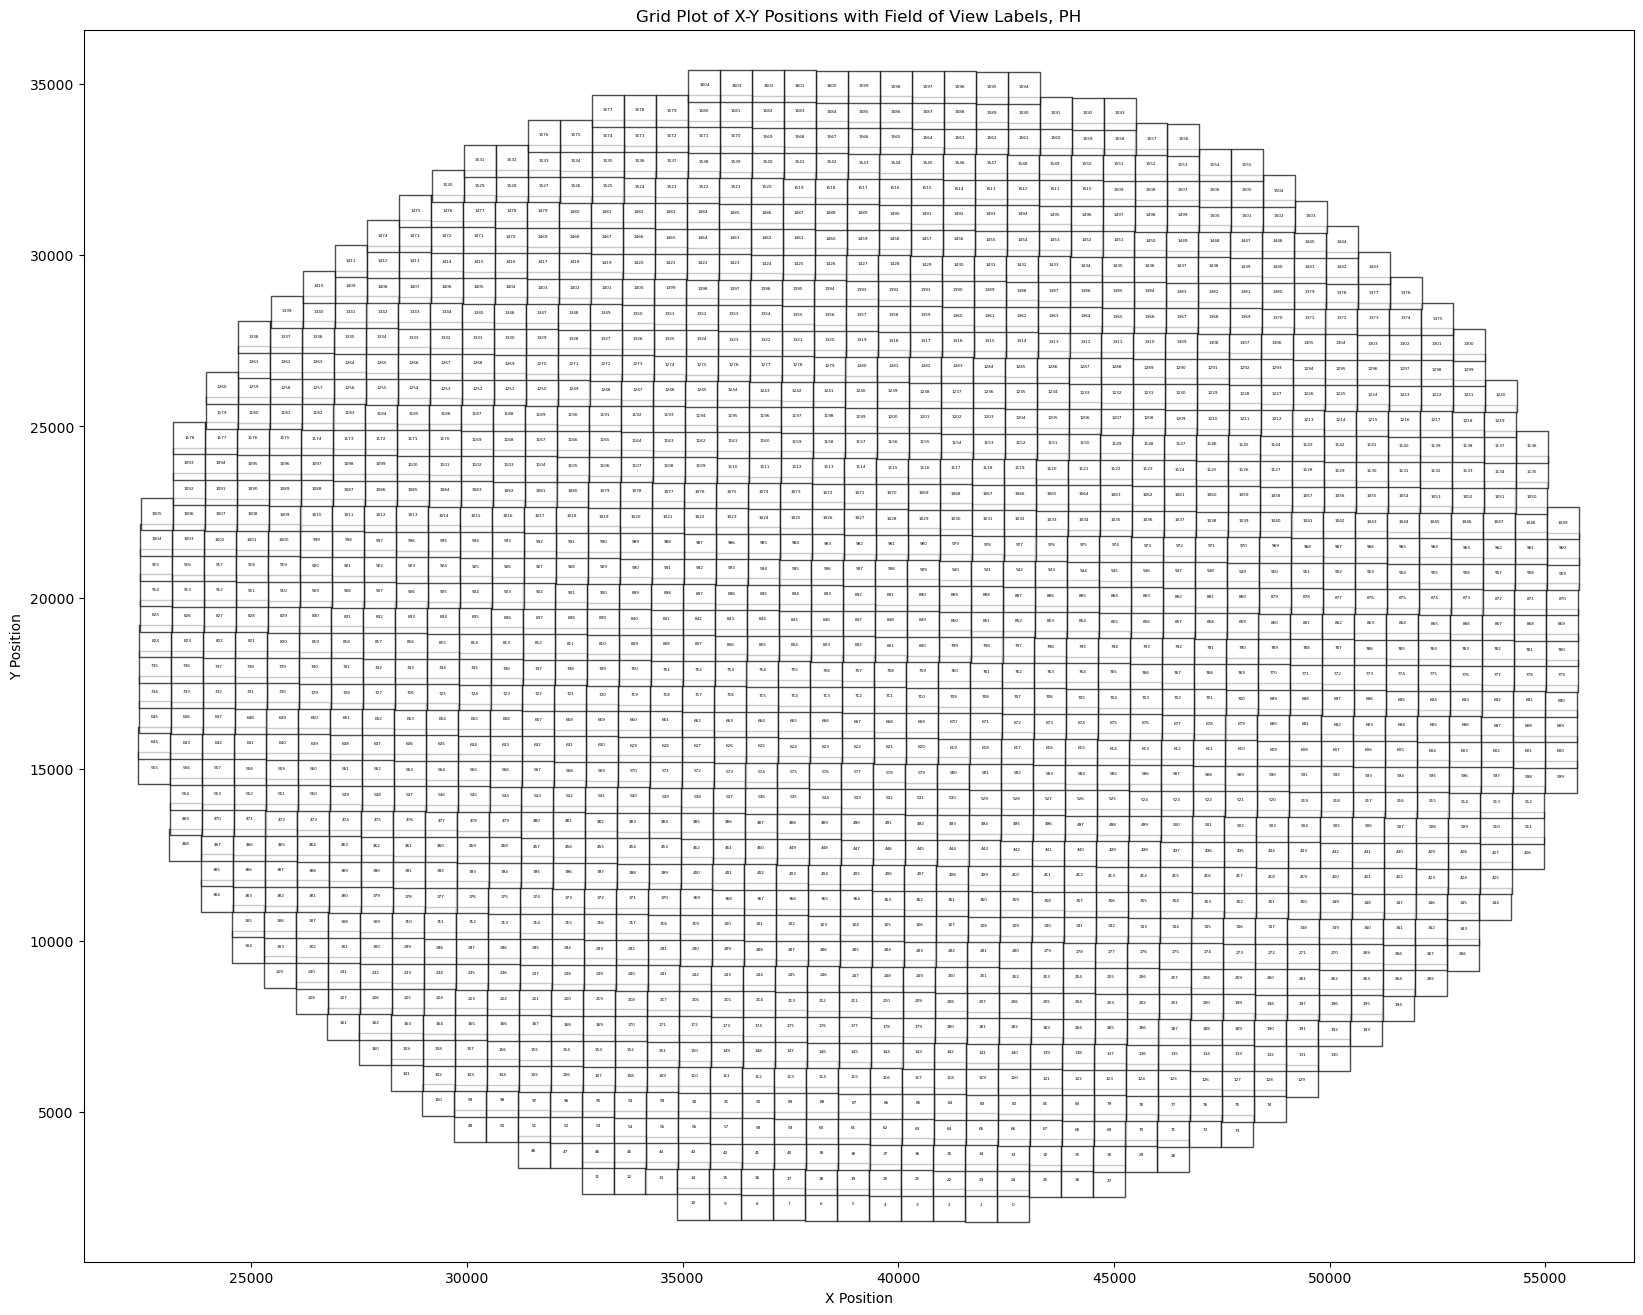

In [39]:
plt.figure(figsize=(20, 16))

# Scatter plot with squares for each point
plt.scatter(
    ph_test_metadata["x_data"],
    ph_test_metadata["y_data"],
    s=500,
    c="white",
    marker="s",
    edgecolors="black",
    linewidths=1,
    alpha=0.7,
)

# Label each point with the 'field_of_view' variable
for i, txt in enumerate(ph_test_metadata["tile"]):
    plt.annotate(
        txt,
        (ph_test_metadata["x_data"].iloc[i], ph_test_metadata["y_data"].iloc[i]),
        textcoords="offset points",
        xytext=(0, 0),
        ha="center",
        fontsize=3,
    )
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Grid Plot of X-Y Positions with Field of View Labels, PH")
plt.show()

In [40]:
sbs_test_metadata

,x_data,y_data,z_data,pfs_offset,tile,filename
0,38953.7,2305.9,3121.78,8063,0,/lab/barcheese01/screens/denali/input_sbs/c1/P...
1,33037.5,3835.2,3120.10,8063,1,/lab/barcheese01/screens/denali/input_sbs/c1/P...
2,34519.6,3823.1,3120.14,8063,2,/lab/barcheese01/screens/denali/input_sbs/c1/P...
3,36001.5,3811.2,3120.12,8063,3,/lab/barcheese01/screens/denali/input_sbs/c1/P...
4,37483.4,3799.5,3120.14,8063,4,/lab/barcheese01/screens/denali/input_sbs/c1/P...
...,...,...,...,...,...,...
372,40684.8,33415.1,3145.72,8063,372,/lab/barcheese01/screens/denali/input_sbs/c1/P...
373,42166.7,33402.8,3145.70,8063,373,/lab/barcheese01/screens/denali/input_sbs/c1/P...
374,43648.9,33391.0,3145.70,8063,374,/lab/barcheese01/screens/denali/input_sbs/c1/P...
375,45130.8,33379.0,3145.72,8063,375,/lab/barcheese01/screens/denali/input_sbs/c1/P...


<Figure size 1000x800 with 0 Axes>

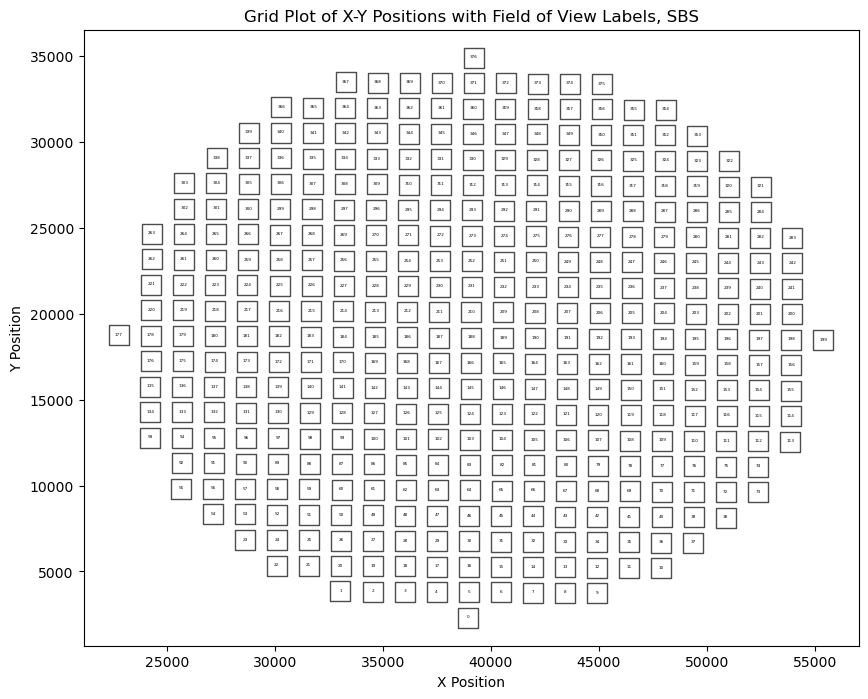

In [35]:
plt.figure(figsize=(10, 8))

# Scatter plot with squares for each point
plt.figure(figsize=(10, 8))

# Scatter plot with squares for each point
plt.scatter(sbs_test_metadata['x_data'], sbs_test_metadata['y_data'], 
            s=200, c='white', marker='s', edgecolors='black', 
            linewidths=1, alpha=0.7)

# Label each point with the 'field_of_view' variable
for i, txt in enumerate(sbs_test_metadata['tile']):
    plt.annotate(txt, (sbs_test_metadata['x_data'].iloc[i], sbs_test_metadata['y_data'].iloc[i]), 
                 textcoords="offset points", xytext=(0,0), ha='center', fontsize=3)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Grid Plot of X-Y Positions with Field of View Labels, SBS')
plt.show()

In [36]:
ph_test_metadata

,x_data,y_data,z_data,pfs_offset,tile,filename
0,42654.6,2273.5,3139.56,10199,0,/lab/barcheese01/screens/denali/input_ph/20240...
1,41913.5,2279.1,3139.52,10199,1,/lab/barcheese01/screens/denali/input_ph/20240...
2,41172.5,2285.2,3139.50,10199,2,/lab/barcheese01/screens/denali/input_ph/20240...
3,40431.7,2290.9,3139.50,10199,3,/lab/barcheese01/screens/denali/input_ph/20240...
4,39690.6,2296.9,3139.56,10199,4,/lab/barcheese01/screens/denali/input_ph/20240...
...,...,...,...,...,...,...
1600,38470.0,34911.9,3166.48,10199,1600,/lab/barcheese01/screens/denali/input_ph/20240...
1601,37728.9,34917.6,3166.58,10199,1601,/lab/barcheese01/screens/denali/input_ph/20240...
1602,36988.0,34923.4,3166.56,10199,1602,/lab/barcheese01/screens/denali/input_ph/20240...
1603,36246.9,34929.6,3166.54,10199,1603,/lab/barcheese01/screens/denali/input_ph/20240...
